# 3. Convolutional Neural Networks (60 pts)

### Implement the convolutional neural network shown below for CIFAR-10 dataset.  Your code must follow these rules:

__- Use your own implementation.__

__- You can only use " tf " and " tf.nn " libraries for version 1 (40 pts). Check [tf.nn](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/nn)__

__- You can use " tf.layers " library for version 2 (20 pts). Check [tf.layers](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers)__

__- Use ReLU activation function__

__- Use batch normalization for convolutional layers__

__- Use dropout for fully connected layers (for training only)__

__- Write necessary explanations for each cell. Explanations should be detailed.__

__- You can use codes from Lab Notebook.__

__- (OPTIONAL) You can add more layers or use different methods for better accuracy. If you want, send an another notebook file with better accuracy for bonus points.__

<img src="https://github.com/METU-MMI-DeepLearning/MMI713_Deep_Learning/blob/master/Assignment%202/model.png?raw=1">

## Imports

In [1]:
%tensorflow_version 1.x" before "import tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x" before "import tensorflow`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


## Load Data

You can normalize input data "x" if needed. You can use "np.squeeze" to remove single-dimensional entries from the shape of an array. You probably need to convert labels "y" to one-hot vector for loss function.

*Load* the CIFAR10 dataset



In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

Normalize the x input data

In [3]:
n_classes = 10
X_train_mean = np.mean(x_train, axis=(0,1,2))
X_train_std = np.std(x_train, axis=(0,1,2))
x_train = (x_train - X_train_mean) / X_train_std
x_test = (x_test - X_train_mean) / X_train_std

print("x_train:")
print(x_train.shape)

x_train:
(50000, 32, 32, 3)


Convert y data to one-hot vector form



In [4]:
print("y_train:")
y_train = np.squeeze(y_train)
y_train = np.eye(np.max(y_train) + 1)[y_train]
print(y_train.shape)
print(y_train[0])

print("y_test:")
y_test = np.squeeze(y_test)
y_test = np.eye(np.max(y_test) + 1)[y_test]
print(y_test.shape)

y_train:
(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
y_test:
(10000, 10)


## Define placeholders

Define input and output placeholders. It is a good idea to pass dropout rate also as a placeholder.

We define the placeholder **x** for the input data with no specific number of samples but with dimensions of a single sample.
We define **y** with no sample number either but with dimensions of a one-hot vector.
**dropout** placeholder is the dropout rate for use to be able to specify the dropout rate during training and to disable the process during test time.

In [0]:
dropout_rate = 0.75

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.float32, [None, n_classes])
dropout = tf.placeholder(tf.float32)

## Define variables

Define filters for convolutional layers, weights and biases for fully connected layers. Don't forget to use a initializer. Xavier is recommended.

We define the parameters inside a dictionary to use them in a higher level. All the variables are initilized with Xavier initilization.

In [0]:
weights = {
    'cl1' : tf.get_variable("ConvFilter1", [5,5,3,32], initializer=tf.glorot_normal_initializer()),
    'cl2' : tf.get_variable("ConvFilter2", [5,5,32,16], initializer=tf.glorot_normal_initializer()),
    'cl3' : tf.get_variable("ConvFilter3", [5,5,16,32], initializer=tf.glorot_normal_initializer()),
    'fc1' : tf.get_variable("DenseWeight1", [512,128], initializer=tf.glorot_normal_initializer()),
    'out' : tf.get_variable("DenseWeight2", [128, n_classes], initializer=tf.glorot_normal_initializer()),
}


In [0]:
biases = {
    'cl1' : tf.get_variable("Bias1", [32], initializer=tf.glorot_normal_initializer()),
    'cl2' : tf.get_variable("Bias2", [16], initializer=tf.glorot_normal_initializer()),
    'cl3' : tf.get_variable("Bias3", [32], initializer=tf.glorot_normal_initializer()),
    'fc1' : tf.get_variable("Bias4", [128], initializer=tf.glorot_normal_initializer()),
    'out' : tf.get_variable("Bias5", [n_classes], initializer=tf.glorot_normal_initializer()),
}

## Define network

Define the network as a function.Recommended functions are:

`
tf.nn.convolution / tf.nn.pool / tf.nn.batch_normalization / tf.nn.dropout / tf.reshape`

The convolution layer method constituted by convolution, adding bias, batch normalziation and ReLU activation.

In [0]:
def conv_layer(x, filter, bias, strides=[1,1]):
  x = tf.nn.convolution(x, filter, "SAME", strides)
  x = tf.nn.bias_add(x, bias)
  x = batch_norm(x, bias.get_shape().as_list()[0])
  x = tf.nn.relu(x)
  
  return x

Max pooling layer using the tf.nn.pool function with setting of max pooling

In [0]:
def maxpool_layer(x, window=[3,3], strides=[2,2], padding="SAME"):
  return tf.nn.pool(x, window, "MAX", padding, strides=strides)


The definition of the CNN. It has convolution, max pooling and dense layers. 

In [0]:
def conv_net(x, weights, biases, dropout_rate):
  conv1 = conv_layer(x, weights['cl1'], biases["cl1"])
  pool1 = maxpool_layer(conv1)
  conv2 = conv_layer(pool1, weights['cl2'], biases['cl2'])
  pool2 = maxpool_layer(conv2)
  conv3 = conv_layer(pool2, weights['cl3'], biases['cl3'])
  pool3 = maxpool_layer(conv3)
  fc1 = tf.reshape(pool3, [-1, weights['fc1'].get_shape().as_list()[0]])
  fc1 = dense_layer(fc1, weights['fc1'], biases['fc1'], dropout_rate)
  logits = dense_layer(fc1, weights['out'], biases['out'], dropout_rate, activation=False)
  softmax_output = tf.nn.softmax(logits)
  return logits, softmax_output


The dense layer definition which does matrix multiplication with the input and the weights and adds the biases. Then, it applies activation and dropout in order.

In [0]:
def dense_layer(x, weight, bias, dropout, activation=True):
  x = tf.add(tf.matmul(x, weight), bias)
  x = tf.nn.dropout(x, dropout)
  if activation:
    x = tf.nn.relu(x)
  return x

Batch normalization layer creates 2 variables every time it is used which are trainable. The batch of inputs is normalized by its mean and variance with the parametrized scaling factors. 

In [0]:
def batch_norm(x, n_out):
    beta = tf.Variable(tf.constant(0.0, shape=[n_out]), trainable=True)
    gamma = tf.Variable(tf.constant(1.0, shape=[n_out]), trainable=True)
    mean, var = tf.nn.moments(x, [0, 1, 2])
    normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

Define the CNN. Outputs are the logits and the spftmax outputs separated.

In [13]:
logits, prediction = conv_net(x, weights, biases, dropout)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Define cost function

Define cost with respect to predictions and labels.

Define the cost function as the cross entropy

In [14]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Define optimizer

Adam is recommended

Define the optimizer as Adam Optimizer

In [0]:
optimizer = tf.train.AdamOptimizer().minimize(cost)


## Define performance measures

The find the number of correct predictions and calculate the overall accuracy

In [0]:
correct_prediction = tf.equal(tf.argmax(prediction, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Create TensorFlow session


In [0]:
session = tf.Session()

## Initialize variables

The variables for `weights`,`filters` and `biases` must be initialized before we start optimizing them.

In [18]:
init = tf.initialize_all_variables()
session.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


## Define train function

Don't forget to use batches since dataset is large.

Hint : One of the simplest way to define batch is

`for b in range(dataset_size//batch_size):      
    x_batch = x_train[b * batch_size : (b+1) * batch_size]`

In [0]:
train_accuracy_on_epoch = []
train_loss_on_epoch = []

test_accuracy_on_epoch = []
test_loss_on_epoch = []



The train function that inputs a batch to the network and gets the accuracy and loss. Then, at the end of each batch, it runs the network with the test set.

In [0]:
def train(epoch_num, batch_size):
  for i in range(epoch_num):
    batch_loss = []
    batch_acc = []
    for b in range(len(x_train)//batch_size): 
      x_batch = x_train[b * batch_size : (b+1) * batch_size]  
      y_batch = y_train[b * batch_size : (b+1) * batch_size]
      _, acc, loss = session.run([optimizer, accuracy, cost], feed_dict={x:x_batch, y: y_batch, dropout:dropout_rate})
      batch_loss.append(loss)
      batch_acc.append(acc)
      
    train_accuracy_on_epoch.append(np.mean(np.array(batch_acc)))
    train_loss_on_epoch.append(np.mean(np.array(batch_loss)))
    
    acc, loss = test(x_test, y_test, i + 1)
    test_accuracy_on_epoch.append(acc)
    test_loss_on_epoch.append(loss)
    

## Define test function

The test function taht feeds the test set to the network. We specify dropout to be 1.0 to avoid it.

In [0]:
def test(x_set, y_set, epoch_no):
  test_acc, loss = session.run([accuracy, cost], feed_dict={x: x_set, y: y_set, dropout:1.0})
  print("Epoch:{} Accuracy:{} Loss:{} ".format(epoch_no, test_acc, loss))
  return test_acc, loss


## Performance before training

The accuracy is expected to be around 10%

In [22]:
acc, loss = test(x_test, y_test, 0)
test_accuracy_on_epoch.append(acc)

Epoch 0: Accuracy:0.08990000188350677 Loss:3.3324038982391357


## Performance after training

Measure training and test accuracy for at least 10 epochs, show it on a epoch/accuracy graph. The network is expected to reach around 70% accuracy at 10 epochs. 

Train the network with batch size being 1000

In [23]:
epoch_number = 10
batch_size = 1000
start_time = time()
train(epoch_number, batch_size)
end_time = time()
print("Took {} seconds to train for {} epochs with batch size {}. Time consumed for 1 epochs is {} seconds".format(end_time - start_time, epoch_number, batch_size, (end_time - start_time)/epoch_number))

Epoch 1: Accuracy:0.4244000017642975 Loss:1.6495277881622314
Epoch 2: Accuracy:0.5180000066757202 Loss:1.406653642654419
Epoch 3: Accuracy:0.5738000273704529 Loss:1.2588708400726318
Epoch 4: Accuracy:0.6039999723434448 Loss:1.1545559167861938
Epoch 5: Accuracy:0.6290000081062317 Loss:1.079553484916687
Epoch 6: Accuracy:0.6406000256538391 Loss:1.0298566818237305
Epoch 7: Accuracy:0.6546000242233276 Loss:0.9887564182281494
Epoch 8: Accuracy:0.6578999757766724 Loss:0.9658730626106262
Epoch 9: Accuracy:0.6790000200271606 Loss:0.9271960258483887
Epoch 10: Accuracy:0.6802999973297119 Loss:0.914101243019104
Took 25.825029611587524 seconds to train for 10 epochs with batch size 1000. Time consumed for 1 epochs is 2.5825029611587524 seconds


# Show the epoch vs accuracy and loss graphs for train and test set

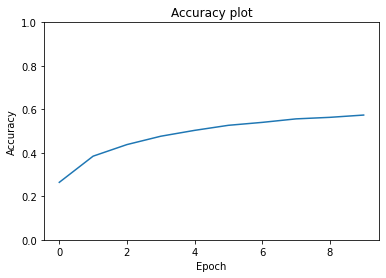

Accuracy on train-set: 57.4%


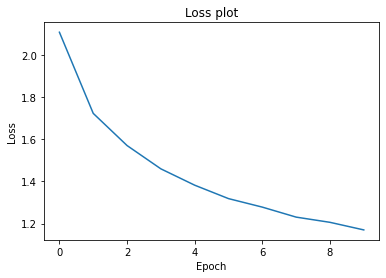

Loss on train-set: 1.1697219610214233


In [24]:
plt.plot(train_accuracy_on_epoch)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(top=1.0, bottom=0.0)
plt.title("Accuracy plot")
plt.show()
print("Accuracy on train-set: {0:.1%}".format(train_accuracy_on_epoch[-1]))

plt.plot(train_loss_on_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.show()
print("Loss on train-set: {}".format(train_loss_on_epoch[-1]))


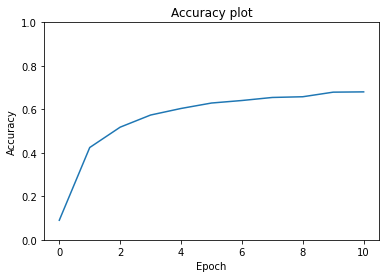

Accuracy on test-set: 68.0%


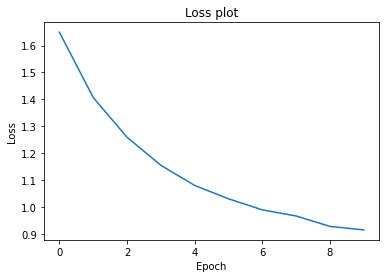

Loss on test-set: 0.914101243019104


In [25]:
plt.plot(test_accuracy_on_epoch)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(top=1.0, bottom=0.0)
plt.title("Accuracy plot")
plt.show()
print("Accuracy on test-set: {0:.1%}".format(test_accuracy_on_epoch[-1]))

plt.plot(test_loss_on_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.show()
print("Loss on test-set: {}".format(test_loss_on_epoch[-1]))


## Close the session

In [0]:
session.close()

## Discussion

In this part of the assignment, I have used the tf.nn and tf libraries to implement a CNN to classify the images of the CIFAR10 dataset. The network contains several types of layers:


*   Convolutional Layers
*   Max Pooling Layers
*   Batch Normalization Layers
*   Flattening Layer
*   Fully Connected Layers
*   Dropout Layers

All the weights of the network are initialized with Xavier initialization method which seems to perform considerably better compared to the random uniform or random normal initializations. The convolutional layers are always followed by adding bias, batch normalization and ReLU activation. The batch normalization normalizes the batch of activations to a 0 mean and 1 variance which fights the internal covariate shift. It also makes the network faster and on top of all regularizes the tensor which can make finding correlations easier. The max pooling layers subsample the activations taken from the convolutional layers, who change the depth of the activation maps by having different numbers of kernels. The feature extraction part of the network is constituted by 3 convolutional and 3 max pooling layers. The classification is done inside a fully connected neural network which starts with the flattening layer which flattens the activation map taken from the last pooling layer of the feature extraction. The dense network contains one hidden layer that also contains a dropout layer which randomly deactivates neurons to prevent overfitting, by letting the network to find different paths to a decision. The last layer applies softmax activation to the logits and gives the predictions. As the cost function, cross entropy was chosen. The learning process was set to minimize this cost function with the help of the Adam optimizer. 

This was the standard implementation of the given CNN, therefore there are a relatively small amount of parameters for the model to be accurate more than 75 percent. In fact, after 100 epochs, the accuracy graph seems to go downwards as the model starts to overfit itself to the train set too much such that it cannot generalize its predictions to the unseen test set. The network is trained at a rate speed of around 2.5s/epoch which translates to 2.5e-10s/sample. This speed is acceptable altough the network is highly shallow compared to the state of the art implementations. The accuracy of the CNN changes between 63-70% for the test set after training for 10 epochs, while interestingly having a considerably smaller 48-51% accuracy on the training set. This probably implies a mistake while computing the training accuracy as it is not resonable to have such low training accuracy while having a respectable degree of test accuracy. On the other hand, this may imply some redundant regularization on the training data.

Overall, this work showed us the low level usage of the tensorflow library. Before moving forward with the more optimized, easier to implement high level libraries such as tf.keras, it is better to learn the basic mechanics of the deep learning practice.

## References

[1] [Arm Community](https://community.arm.com)